In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

import torch
import json
import os
import pandas as pd
from pprint import pprint
from forecasting_dataset import SimulationDataset
from forecasting_nn import SimulationForecasting
from pprint import pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0


## Calculate the saliencies using the validation dataset for each model

In [8]:
from tqdm.auto import tqdm

def compute_saliency(model, phi):
    '''
    Make predictions of the time derivative for each time point in sample
    Compute saliency using those predictions
    model is a neural network whose forward function predicts the time derivative
    phi is a [T, C, H, W] shaped FloatTensor which is a time series of occupation fractions
    '''
    loc = torch.zeros(phi.shape[-2:], dtype=phi.dtype, device=phi.device)
    G_S_sum = np.zeros(phi.shape[-2:])

    print(phi[0,0].cpu().numpy().shape)

    mask = np.ones(phi.shape[-2:], dtype=bool)
    nnz = np.asarray(np.nonzero(mask)).T
    for tt in tqdm(range(phi.shape[0])):
        G_S = []
        inputs = phi[tt:tt+1].clone()
        inputs.requires_grad = True
        dt_phi = model(inputs)

        # Select 100 random points to compute saliency
        np.random.shuffle(nnz)
        pts = nnz[:100]

        # print(loc.shape, pts)

        # Compute prediction saliency
        G_S = []
        for pt in pts:
            loc[:] = 0.
            loc[pt[0], pt[1]] = 1.

            grad = torch.autograd.grad(dt_phi[0,0],inputs, grad_outputs=loc, retain_graph=True)[0]
            G_S.append(grad.detach().cpu().numpy().squeeze())

        # Shift gradients to have common origin
        center = np.asarray([G_S[0].shape[-2]/2, G_S[0].shape[-1]/2]).astype(int)
        shifts = np.asarray(center-pts)
        G_S_shifted = np.asarray([np.roll(g, shift, axis=(-2,-1)) for shift, g in zip(shifts, G_S)])

        # Add to aggregated G_S_sum
        G_S_sum += np.sum(G_S_shifted, axis=0)
        
    return G_S_sum

for i in range(4):
    model_path = f'models/SimulationForecasting_sigma10_{i}'
    
    # Load model
    info = torch.load(f'{model_path}.ckpt')
    model = SimulationForecasting().to(device)
    model.load_state_dict(info['state_dict'])
    model.eval();
    
    # Get validation set simulation
    with open(f'{model_path}_args.txt', 'r') as f:
        info = json.load(f)
    
        G_S_sum = 0
    
        for folder in np.random.choice(info['val_folder'], 5):
            ds = SimulationDataset(folder, seq_len=25, sigma=info.get('sigma', 0))
    
            sample = ds[0]
            phi = sample['phi'].to(device)
            G_S_sum += compute_saliency(model, phi)
    
        np.save(f'{model_path}_saliency.npy', G_S_sum)

(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:07<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:07<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:07<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:07<00:00,  2.72s/it]


(256, 256)


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


## Plot the saliencies

FileNotFoundError: [Errno 2] No such file or directory: 'models/SimulationForecasting_sigma10_0_saliency.npy'

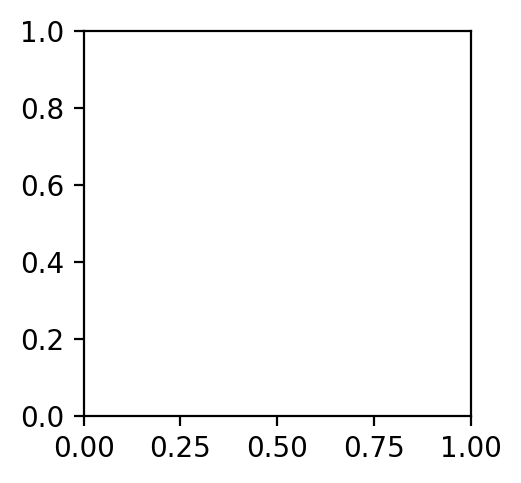

In [5]:
ds = SimulationDataset('/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n01', seq_len=25, sigma=10)


X = ds.x - np.mean(ds.x)
Y = ds.y - np.mean(ds.y)

def get_Gr(G_r, x=X , y=Y):
    G_r = G_r / np.abs(G_r).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack([x, y]), axis=0)
    r = np.linspace(0., np.max(rgrid), 100)
    dr = r[1] - r[0]
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(G_r[np.abs(rgrid - r[j]) <= dr])
        
    return r, gr

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(2.5, 2.5))

G_r = []

for i in range(4):
    model_path = f'models/sigma10/SimulationForecasting_sigma10_{i}'
    G_s = np.load(f'{model_path}_saliency.npy')
    
    r, gr = get_Gr(G_s)
    G_r.append(gr)

G_r = np.stack(G_r)
G_mean = np.mean(G_r, axis=0)
G_std = np.std(G_r, axis=0)

ax.plot(r, G_mean, color='black')
ax.fill_between(r, G_mean-G_std, G_mean+G_std, color='black', alpha=0.3)

ax.set(
    xlabel='$r$',
    ylabel='$\kappa(r)$'
)
ax.tick_params(which='both', direction='in')
ax.grid(True)

fig.savefig('Figures/saliency_plot.pdf', bbox_inches='tight')